# VQ Layer Embedding Space $\alpha$-Training Evaluation

The embedding space of a VQ layer can be trained. This notebook evaluates whether (1) vectors in the embeddings pace are moving into the direction of the points that are being projected onto them and (2) vectors remain in-place if they are not being used at all (opposed to $k$-means clustering).

We call this kind of training $\alpha$-training because vectors are being affected by three kinds of losses and this one has the coefficient $\alpha$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def vector_quantization(x: tf.Tensor, n, alpha=0.1, lookup_ord='euclidean', embedding_initializer=tf.random_normal_initializer) -> tf.Tensor:
    """Simplified version of the function in vq-layer-function, without losses beta and gamma and gradient skipping."""
    # shape of x is [batch, , q], where this function quantizes along dimension q
    vec_size = x.shape[2]
    with tf.variable_scope('vq'):
        # embedding space
        emb_space = tf.get_variable('emb_space', shape=[n, vec_size], dtype=x.dtype, initializer=embedding_initializer, trainable=True)
        
        # map x to y, where y is the vector from emb_space that is closest to x
        diff = tf.expand_dims(x, axis=2) - emb_space  # distance of x from all vectors in the embedding space
        dist = tf.norm(diff, lookup_ord, axis=3)  # distance between x and all vectors in emb
        emb_index = tf.argmin(dist, axis=2)
        y = tf.gather(emb_space, emb_index, axis=0)

        # closest embedding update loss
        nearest_loss = tf.reduce_mean(alpha * tf.norm(y - x, lookup_ord, axis=2), axis=[0, 1])
        tf.add_to_collection(tf.GraphKeys.LOSSES, nearest_loss)
        
        return y, emb_space

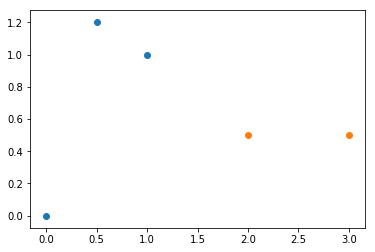

In [3]:
points_val = np.array([[0, 0], [1, 1], [0.5, 1.2]], dtype=np.float32)
emb_space_val = np.array([[2, 0.5], [3, 0.5]], dtype=np.float32)

plt.scatter(points_val[:, 0], points_val[:, 1])
plt.scatter(emb_space_val[:, 0], emb_space_val[:, 1])

The step size $\alpha$ determines how quickly the embedding space is being adjusted.

In [4]:
alpha = 0.1

In [5]:
tf.reset_default_graph()
points = tf.placeholder(tf.float32, shape=[None, 2])
vq_in = tf.expand_dims(points, axis=1)
vq_out, emb_space = vector_quantization(vq_in, len(emb_space_val), alpha, lookup_ord=2, embedding_initializer=tf.constant_initializer(emb_space_val))
points_out = tf.squeeze(vq_out)

In [6]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)
    loss = tf.add_n(tf.get_collection(tf.GraphKeys.LOSSES))
    train_op = optimizer.minimize(loss)

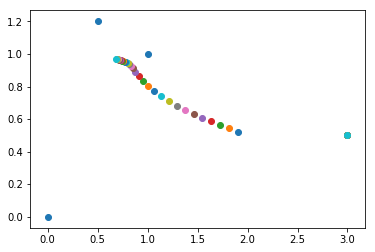

In [7]:
sess = tf.Session()
with sess.as_default():
    sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
    for _ in range(30):
        emb_space_learned, _ = sess.run([emb_space, train_op], feed_dict={points:points_val})
        plt.scatter(emb_space_learned[:, 0], emb_space_learned[:, 1])
    plt.scatter(points_val[:, 0], points_val[:, 1])

The plot shows how the embedding vector in them middle is moving towards the _cluster_ center, following the gradient. The chosen hyperparameters are
* learning rate $\eta=1$
* update weighting $\alpha=0.1$
* iterations $n=50$